Le rapport qui suit a été fait dans le cadre d'une mission réalisée à la demande de la société "Prêt à Dépenser" et qui consiste essentiellement à implémenter un modèle de scoring. En effet, le crédit à la consommation constitue une activité clé pour "Prêt à Dépenser", société financière qui accorde des prêts à des clients ayant peu ou pas d’historique de crédit. Toutefois, l’octroi de crédits comporte un risque financier important si les emprunteurs ne parviennent pas à rembourser.

Pour réduire ce risque, "Prêt à Dépenser" souhaite développer un outil de scoring crédit capable de :
- Prédire la probabilité de défaut de paiement d’un client.
- Classer automatiquement les demandes en deux catégories : crédit accordé ou crédit refusé.

L’objectif principal est ici d’allier efficacité et transparence pour optimiser la prise de décision et minimiser les risques financiers. Ce projet va également intégrer des pratiques MLOps pour industrialiser le processus, garantir la traçabilité et faciliter la maintenance du système à long terme.

Nous allons ainsi décliner les objectifs du projet en plusieurs volets :
- Construire un modèle de classification robuste pour prédire les risques de crédit, en tenant compte des déséquilibres dans les données et des impacts métier des erreurs de classification.
- Interpréter les prédictions du modèle à l’échelle globale (importance des variables) et locale (rôle des variables pour un client donné).
- Déployer le modèle via une API accessible permettant d’interroger le système avec des données clients.
- Mettre en œuvre une approche MLOps complète, comprenant le suivi des expérimentations, la gestion des modèles, et l’automatisation des déploiements avec des outils open-source.

Pour débuter la construction de notre modèle, nous allons tout d'abord importer nos données. Pour cela, nous disposons d'un kernel concu pour la préparation de nos données et le feature engineering qui y est associé. Il s'agit du code qui va suivre et qui documente une méthode rigoureuse pour télécharger et prétraiter des données utilisées dans une compétition de Machine Learning (HOME CREDIT DEFAULT RISK COMPETITION). Voici une explication détaillée de ce que fait ce code et pourquoi chaque étape est importante dans le cadre du projet.

Comme mentionné, ce segment de code décrit un processus où les données sont déjà prétraitées (les données initiales contiennent des caractéristiques (features) créées à partir de différentes tables en utilisant des opérations groupées (comme min, max, mean, sum, var)) et une grande partie du feature engineering est effectuée pour simplifier la modélisation ultérieure. Cela inclut la création de ratios et de nouvelles variables qui capturent des relations importantes entre les données originales:

- Création de Nouvelles Variables : division et soustraction de variables importantes, par exemple, des ratios comme le taux de paiement (Payment Rate) ou la relation entre l'annuité et le revenu (Annuity/Income) permettent de capturer des informations cruciales sur la capacité d'un client à rembourser un prêt. Ces nouvelles variables aident à détecter des patrons dans les données qui pourraient être difficiles à voir dans les variables brutes.
- Traitement des Données Bureau : les crédits précédents du client (données Bureau) sont divisés en deux catégories principales. Il y a d'un côté les Crédits Actifs (Ceux qui sont encore en cours) et de l'autre les Crédits Clôturés (Ceux qui ont été remboursés ou annulés). Des caractéristiques spécifiques sont calculées pour chaque groupe, ce qui permet de mieux comprendre l’historique financier du client.
- Applications Précédentes : les demandes de crédit antérieures sont séparées selon leur statut (approuvées ou refusées). Ces distinctions permettent d’évaluer la cohérence et la stabilité des comportements financiers des clients dans le passé.
- Modularité du Code : chaque table est traitée indépendamment par une fonction dédiée. Cela rend le code plus lisible et maintenable, et cette approche modulaire facilite la mise à jour ou l’ajout de nouvelles transformations.
- Encodage des Variables Catégoriques : un encodage one-hot est appliqué pour transformer les variables catégoriques en représentations numériques. Cela permet de conserver les informations des catégories tout en rendant les données compatibles avec les modèles de Machine Learning.
- Fusion des Données : toutes les tables sont jointes à la table principale application en utilisant la clé commune SK_ID_CURR. Une seule exception, cependant : la table bureau_balance est probablement trop volumineuse ou complexe pour être fusionnée directement.
- Ajout de nouvelles variables clés : Une fonctionnalité importante, Payment Rate, a été ajoutée dans une mise à jour pour améliorer les prédictions.
- Éviter le surajustement : Avec un grand nombre de variables, certaines peuvent être corrélées entre elles, ce qui peut causer un surajustement si le modèle n’est pas bien régularisé.
- Validation croisée : L’utilisation de la validation croisée avec KFold (et non Stratified KFold) permet de tester la robustesse du modèle sur des partitions différentes des données.

Ce processus pré-traite donc les données de manière avancée, facilitant leur utilisation pour entraîner des modèles de Machine Learning. En documentant chaque étape (création de variables, séparation des tables, et encodage des catégories), ce code montre comment obtenir un jeu de données prêt pour la modélisation tout en minimisant le risque d’erreurs ou d’omissions dans le pipeline.

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title: str):
    """Un gestionnaire de contexte pour mesurer le temps d'exécution."""
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    """
    Effectue l'encodage one-hot des colonnes catégorielles dans un DataFrame.
    """
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Effectuer l'encodage one-hot
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    # Identifier les nouvelles colonnes créées
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    """
    Lit les données d'application pour l'entraînement et le test, et effectue des transformations de données.
    """
    # Read data and merge
    df = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows=num_rows)
    print("Train samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    # Garbage collection to free up memory
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    """
    Lit les données du bureau et de l'historique de crédit, effectue des transformations et des agrégations.
    """
    # Lire les fichiers bureau et bureau_balance
    bureau = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv', nrows=num_rows)
    # One-hot encoding pour bureau_balance et bureau
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Agrégations pour bureau_balance et fusion avec bureau
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([f"{e[0]}_{e[1].upper()}" for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    
    # Agrégations numériques pour bureau et bureau_balance
    num_aggregations = {'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
                        'DAYS_CREDIT_UPDATE': ['mean'],'CREDIT_DAY_OVERDUE': ['max', 'mean'],
                        'AMT_CREDIT_MAX_OVERDUE': ['mean'],'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
                        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],'AMT_CREDIT_SUM_OVERDUE': ['mean'],
                        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],'AMT_ANNUITY': ['max', 'mean'],
                        'CNT_CREDIT_PROLONG': ['sum'],'MONTHS_BALANCE_MIN': ['min'],'MONTHS_BALANCE_MAX': ['max'],
                        'MONTHS_BALANCE_SIZE': ['mean', 'sum']}
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    # Agrégations globales
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index([f"BURO_{e[0]}_{e[1].upper()}" for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index([f"ACTIVE_{e[0]}_{e[1].upper()}" for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index([f"CLOSED_{e[0]}_{e[1].upper()}" for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    """
    Process previous_application.csv and aggregate features by SK_ID_CURR.
    """
    # Read previous applications data
    prev = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv', nrows=num_rows)
    # One-hot encode categorical features
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Replace specific values with NaN
    for col in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        prev[col] = np.where(prev[col] == 365243, np.nan, prev[col])
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {'AMT_ANNUITY': ['min', 'max', 'mean'],'AMT_APPLICATION': ['min', 'max', 'mean'],
                        'AMT_CREDIT': ['min', 'max', 'mean'],'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
                        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
                        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
                        'DAYS_DECISION': ['min', 'max', 'mean'],'CNT_PAYMENT': ['mean', 'sum'],}
    # Previous applications categorical features
    cat_aggregations = {cat: ['mean'] for cat in cat_cols}

    # Aggregate features by SK_ID_CURR    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    # Clean up memory
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    """
    Process POS_CASH_balance data and aggregate features by SK_ID_CURR.
    """
    # Read the data
    pos = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv', nrows=num_rows)
    # One-hot encoding for categorical features
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],'SK_DPD': ['max', 'mean'],'SK_DPD_DEF': ['max', 'mean']}
    # Add mean aggregation for categorical columns
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Group and aggregate
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count POS cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    # Clean up memory
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    """
    Process installments payments data and aggregate features by SK_ID_CURR.
    """
    ins = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv', nrows=num_rows)
    # One-hot encoding for categorical features
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    # Replace negative values with 0
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {'NUM_INSTALMENT_VERSION': ['nunique'],'DPD': ['max', 'mean', 'sum'],'DBD': ['max', 'mean', 'sum'],
                    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
                    'AMT_INSTALMENT': ['max', 'mean', 'sum'],'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
                    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']}
    # Check if SK_ID_CURR is in the DataFrame
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    # Group and aggregate
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    # Clean up memory
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    """
    Process credit card balance data and aggregate features by SK_ID_CURR.
    """
    # Read the data
    cc = pd.read_csv('Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv', nrows=num_rows)
    # One-hot encoding for categorical features
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    # Clean up memory
    del cc
    gc.collect()
    return cc_agg

# Display/plot feature importance
def display_importances(feature_importance_df_):
    """
    Display the feature importances using a bar plot.
    """
    # Aggregate feature importance
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    # Create the bar plot
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    plt.close()

def main(debug = False):
    num_rows = 50000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    for col in df.select_dtypes(include='object').columns:
        # Essayez de convertir en numérique
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            # Si une colonne contient des catégories, appliquez un LabelEncoder
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    # with timer("Run LightGBM with kfold"):
    #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    return df

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        dfs = main(debug = False)

Train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 28s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 35s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 27s
Full model run - done in 142s


Maintenant que nous avons importé notre base de données en l'ayant, au préalable, préparé de sorte qu'il puisse être exploitable de manière optimale. Nous pouvons désormais mettre en place un pipeline de modélisation avancé avec MLflow.

Le code qui va suivre implémente donc un pipeline complet pour développer, tester et optimiser un modèle de scoring crédit. Le pipeline intègre plusieurs étapes clés, allant de la préparation des données jusqu'à la validation des modèles et leur suivi expérimental avec MLflow. Ce code intègre ainsi les étapes suivantes : 
- Gestion des données
- Nettoyage et transformation des données.
- Gestion des colonnes avec des valeurs manquantes grâce à des imputations adaptées.
- Application d'une normalisation ou une standardisation sur les variables numériques.
- Sauvegarde et documentation des colonnes transformées pour un suivi rigoureux.
- Détection et traitement du déséquilibre de classes.

Concernant la dernière étape, nous aurons recours à la méthode SMOTE (Synthetic Minority Oversampling Technique) pour équilibrer les classes et améliorer la performance des modèles sur les données sous-représentées. Ainsi donc, après avoir effectué ces étapes, nous disposerons d'une base de données opérationnelle sur laquelle nous serons en mesure d'entraîner et d'expérimenter une série de modèles.

Ce code va, en effet, dans un deuxième temps, tester différents algorithmes, tels que la régression logistique, les forêts aléatoires, les gradient boosting et LightGBM. Pour se faire, nous effectuerons des recherches d'hyperparamètres via GridSearchCV, ce qui nous permettra de comparer et d'optimiser la performance des modèles. La performance et la fiabilité de chaque modèle expérimenté sera mesurée à travers la définition d'une métrique métier personnalisée. Cette métrique prendra en compte le coût associé aux faux positifs et faux négatifs, et servira à évaluer les modèles de manière spécifique au contexte métier, et ainsi de sélectionner celui qui sera le plus approprié pour remplir notre objectif principal.

L'ensemble de ces expérimentations, hyperparamètres et résultats seront traquées dans une interface centralisée via MLflow. Les modèles entraînés et leurs signatures pour un déploiement futur seront ainsi enregistrées et publiées dans un registre de modèles (Model Registry) pour une gestion centralisée.

L'ensemble du code peut donc se résumer comme suit : 
- Initialisation de MLflow : Configuration de l'environnement pour le suivi des expérimentations.
- Prétraitement des données : Suppression des colonnes entièrement manquantes, imputation des valeurs manquantes, et standardisation des données numériques.
- Création d'un pipeline intégrant les étapes de prétraitement, de gestion des classes déséquilibrées, et des modèles à tester.
- Comparaison des modèles selon des métriques techniques (accuracy, AUC, F1) et métier.
- Log et gestion des modèles : Utilisation de MLflow pour enregistrer les artefacts, les métriques, et les versions des modèles dans un registre.

L'ensemble de ces démarches permettent une transparence : en traquant toutes les étapes du pipeline, chaque décision est documentée et accessible. De plus, les pipelines modulaires et les enregistrements dans MLflow assurent que chaque expérimentation peut être reproduite. Enfin, l'intégration d'une métrique métier permet d'aligner la performance des modèles sur les objectifs de l'entreprise. En suivant ce pipeline, nous visons donc à construire un modèle de scoring crédit robuste et optimisé, tout en garantissant sa mise en production dans un environnement contrôlé et traçable.

In [4]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "12"

import mlflow
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer
from sklearn.utils.validation import check_is_fitted
from imblearn.pipeline import Pipeline as ImbPipeline
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException
import joblib

# Initialisation de l'expérience MLFlow
mlflow.set_tracking_uri("mlruns")
mlflow.create_experiment("Credit_Scoring_4")
mlflow.set_experiment("Credit_Scoring_4")

df = dfs.sample(n=50000)

# Classe pour supprimer les colonnes entièrement manquantes
class DropMissingColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_to_drop = X.columns[X.isnull().mean() == 1.0]
        return self
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

def custom_metric(y_true, y_pred, X_test):
    credit_amounts = X_test['AMT_CREDIT'].values  # Accéder à AMT_CREDIT depuis X_test
    FN_mask = (y_true == 1) & (y_pred == 0)
    FP_mask = (y_true == 0) & (y_pred == 1)
    FN_cost = -np.sum(credit_amounts[FN_mask])/1000000
    FP_cost = (-np.sum(credit_amounts[FP_mask])*0.19)/1000000
    return FN_cost + FP_cost

# Scorer personnalisé
def custom_scorer(estimator, X, y):
    return custom_metric(y, estimator.predict(X), X)

# Préparer le DataFrame et les colonnes
df.replace([np.inf, -np.inf], np.nan, inplace=True)
feats = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
df[feats] = df[feats].astype('float64')

# Séparer les données
X = df[feats]
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sauvegarder les colonnes originales
columns_path = "columns.pkl"
with open(columns_path, "wb") as f:
    joblib.dump(X_train.columns.tolist(), f)

# Démarrer un run MLflow avec le nom "Original Columns"
with mlflow.start_run(run_name="Original Columns"):
    # Enregistrer l'artefact avec les colonnes
    mlflow.log_artifact(columns_path)

# Pipeline de prétraitement
numeric_transformer = Pipeline(steps=[('drop_missing_columns', DropMissingColumns()),('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, feats)])
smote = SMOTE(random_state=42)

# Modèles à tester
models = {"Dummy Classifier":DummyClassifier(strategy="most_frequent"),"Logistic Regression": LogisticRegression(max_iter=1000),
          "Random Forest": RandomForestClassifier(),"Gradient Boosting": GradientBoostingClassifier(),
          "LightGBM": LGBMClassifier(min_split_gain=0.01, verbosity=-1)}

# Grilles d'hyperparamètres
param_grids = [{},{'model__C': [0.1, 1, 10]},{'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10]},
               {'model__n_estimators': [50, 100, 150], 'model__max_depth': [3, 5]},
               {'model__n_estimators': [50, 100, 150], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}]

results = []

# Boucle sur les modèles
for (name, model), param_grid in zip(models.items(), param_grids):
    print(f"### Starting Grid Search for: {name} ###")
    pipe = ImbPipeline(steps=[("preprocessor", preprocessor),("smote", smote),("model", model)])
    grid_search = GridSearchCV(pipe, param_grid, scoring=custom_scorer, cv=3)
    grid_search.fit(X_train, y_train)

    for params in zip(grid_search.cv_results_['params']):
        print(f"Params: {params} - Done")

    # Meilleur modèle et prédictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)
    train_cost = grid_search.best_score_
    test_cost = grid_search.score(X_test, y_test)

    # Log MLFlow
    if mlflow.active_run() is not None:
        mlflow.end_run()
    
    with mlflow.start_run(run_name=name):
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("train_cost", train_cost)
        mlflow.log_metric("test_cost", test_cost)

        # Signature et modèle
        signature = infer_signature(X_train, best_model.predict(X_train))
        mlflow.sklearn.log_model(best_model, "model", signature=signature)

        # Enregistrer dans le Model Registry
        client = MlflowClient()
        try:
            client.create_registered_model(name)
        except MlflowException as e:
            if 'already exists' not in str(e):
                raise
        run_id = mlflow.active_run().info.run_id
        client.create_model_version(name=name, source=f"runs:/{run_id}/model", run_id=run_id)

    # Ajouter les résultats au tableau
    results.append({'Model': name,'Best Parameters': grid_search.best_params_,'Accuracy': accuracy,'ROC AUC': roc_auc,'F1 Score': f1,
                    "Best Score":train_cost,"Test Score":test_cost})
    print(f"### Finished Grid Search for: {name} ###\n")

results_df = pd.DataFrame(results)
results_df

### Starting Grid Search for: Dummy Classifier ###


C:\Users\Alex-\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Alex-\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Params: ({},) - Done
### Finished Grid Search for: Dummy Classifier ###

### Starting Grid Search for: Logistic Regression ###
Params: ({'model__C': 0.1},) - Done
Params: ({'model__C': 1},) - Done
Params: ({'model__C': 10},) - Done
### Finished Grid Search for: Logistic Regression ###

### Starting Grid Search for: Random Forest ###
Params: ({'model__max_depth': 5, 'model__n_estimators': 50},) - Done
Params: ({'model__max_depth': 5, 'model__n_estimators': 100},) - Done
Params: ({'model__max_depth': 5, 'model__n_estimators': 150},) - Done
Params: ({'model__max_depth': 10, 'model__n_estimators': 50},) - Done
Params: ({'model__max_depth': 10, 'model__n_estimators': 100},) - Done
Params: ({'model__max_depth': 10, 'model__n_estimators': 150},) - Done
### Finished Grid Search for: Random Forest ###

### Starting Grid Search for: Gradient Boosting ###
Params: ({'model__max_depth': 3, 'model__n_estimators': 50},) - Done
Params: ({'model__max_depth': 3, 'model__n_estimators': 100},) - Done
Para

,Model,Best Parameters,Accuracy,ROC AUC,F1 Score,Best Score,Test Score
0,Dummy Classifier,{},0.9200,0.500000,0.000000,-603.876231,-449.300862
1,Logistic Regression,{'model__C': 0.1},0.7241,0.734053,0.262102,-596.819535,-452.275869
2,Random Forest,"{'model__max_depth': 10, 'model__n_estimators'...",0.8840,0.692215,0.169054,-575.384046,-439.392678
3,Gradient Boosting,"{'model__max_depth': 5, 'model__n_estimators':...",0.9189,0.753027,0.064591,-586.736425,-440.213260
4,LightGBM,"{'model__learning_rate': 0.01, 'model__max_dep...",0.8927,0.680899,0.167572,-583.965870,-432.920272


Le tableau ci-dessus résume les performances des différents modèles testés à l'aide de la recherche par grille (Grid Search). Voici les principaux enseignements à en tirer :
- Dummy Classifier : ce modèle, servant de référence de base, affiche une précision (Accuracy) de 92 %, mais cela est trompeur. Cette performance découle de la distribution déséquilibrée des classes et ne reflète pas une réelle capacité de prédiction. Le coût est particulièrement élevé, ce qui confirme l'inefficacité du modèle.
- Logistic Regression : ce modèle offre une amélioration notable avec une précision de 72,41 % et un score ROC AUC de 73,41 %. Cela montre une meilleure discrimination entre les classes. De plus, le faible paramètre de régularisation favorise la généralisation.
- Random Forest : ce modèle atteint une précision de 88,40 % avec un ROC AUC de 69,22 %. Cependant, le F1 Score reste faible (16,91 %), ce qui reflète une mauvaise gestion des classes minoritaires.
- Gradient Boosting : avec une précision de 91,89 % et un score ROC AUC de 75,30 %, ce modèle surpasse le Random Forest. Toutefois, son F1 Score de 6,46 % montre qu'il reste une marge d'amélioration dans la prise en compte des classes minoritaires.
- LightGBM : ce modèle offre une combinaison équilibrée de précision (89,27 %) et de score ROC AUC (68,09 %), avec un F1 Score (16,76 %) proche de celui du Random Forest.

Ainsi, en analysant le Test Score, le modèle LightGBM est celui qui affiche la meilleure performance globale avec un score de -432.92, indiquant qu'il minimise les coûts associés aux erreurs de prédiction tout en offrant une performance satisfaisante. En effet, les paramètres trouvés lors de la recherche par grille ont montré leur efficacité. Cependant, ces résultats peuvent encore être affinés. Même si LightGBM a déjà démontré sa supériorité lors de la recherche par grille, il est possible que des ajustements plus précis autour des paramètres initiaux permettent d’extraire encore davantage de performances. Ce type de recherche locale est particulièrement utile dans des cas complexes où des modèles de type boosting (comme LightGBM ou Gradient Boosting) peuvent bénéficier de configurations très spécifiques.

La suite du rapport aura donc pour objectifs principaux : 
- La sélection dynamique du meilleur modèle parmi ceux évalués.
- L'extraction de ses hyperparamètres optimaux pour explorer une plage plus fine de valeurs. Cela permet de tester si de légères modifications autour des paramètres trouvés peuvent améliorer les performances.
- La comparaison des performances du modèle affiné avec un modèle de base (Baseline) pour vérifier si les ajustements apportent une valeur ajoutée.

Ainsi donc, le modèle est récupéré à partir des résultats précédents, en se basant sur la colonne Test Score. Ce score représente la performance sur l'ensemble de test, et LightGBM est actuellement celui qui minimise au mieux les erreurs tout en maximisant les scores pertinents. Les hyperparamètres associés au meilleur modèle sont également extraits. Dans ce cas, nous récupérons uniquement les paramètres relatifs au modèle (model__*) en éliminant ceux du prétraitement pour nous concentrer sur les ajustements les plus impactants.

Dans un deuxième temps, une baseline est construite pour servir de référence. Ici, elle repose sur une pipeline avec une régression logistique standard, entraînée avec les mêmes étapes de prétraitement et d'équilibrage des classes (via SMOTE). Le score de la baseline sera comparé à celui du modèle LightGBM optimisé.

Enfin, ce code ajustera les hyperparamètres déjà optimaux autour d’une plage définie :
- Si le paramètre n_estimators est présent, une plage autour de sa valeur optimale (par exemple, ±25) est explorée.
- Si le paramètre C (lié à la régularisation pour certains modèles comme la régression logistique) est utilisé, une plage linéaire est générée pour tester des valeurs proches de l’optimum.
De cette manière, une boucle permet de tester différentes valeurs dans cette plage et d’entraîner un modèle temporaire pour chaque valeur. Les scores correspondants sont calculés et enregistrés pour chaque ajustement.

Une fois tous les modèles testés, leurs scores sont comparés à celui de la baseline à l’aide d’un graphique. Cela permet de visualiser clairement si le modèle affiné dépasse la performance de la baseline et dans quelle mesure. Une courbe sera alors tracée pour illustrer la performance du meilleur modèle en fonction des variations de l’hyperparamètre ajusté. 

Même si LightGBM a déjà démontré sa supériorité lors de la recherche par grille, il est possible que des ajustements plus précis autour des paramètres initiaux permettent d’extraire encore davantage de performances. Ce type de recherche locale est particulièrement utile dans des cas complexes où des modèles de type boosting (comme LightGBM ou Gradient Boosting) peuvent bénéficier de configurations très spécifiques.

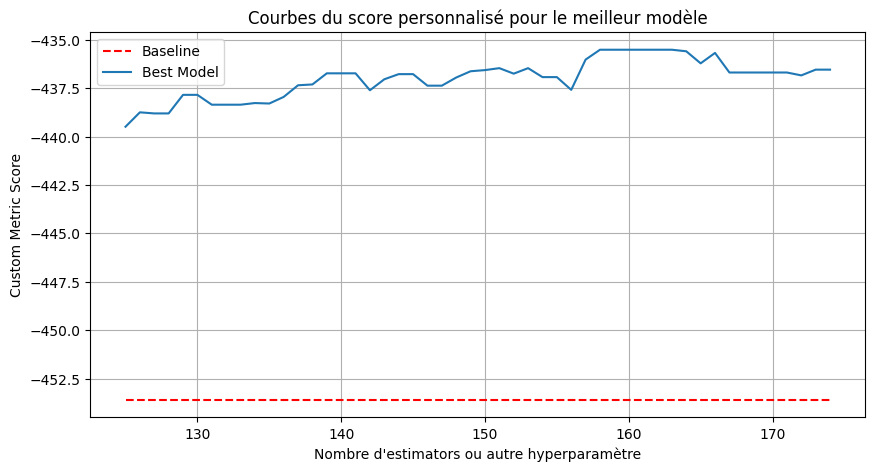

In [5]:
# Sélectionner le modèle avec le meilleur score
best_model = models[results_df.loc[results_df['Test Score'].idxmax(), 'Model']]
best_params = results_df.loc[results_df['Test Score'].idxmax(), 'Best Parameters']

# Extraire les paramètres de prétraitement et du modèle
# preprocessor_params = {key.replace("preprocessor__num__", ""): value for key, value in best_params.items() if "preprocessor__num__" in key}
model_params = {key.replace("model__", ""): value for key, value in best_params.items() if "model__" in key}

baseline_pipeline = ImbPipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=42)),
                                       ("model", LogisticRegression(max_iter=1000))])
baseline_pipeline.fit(X_train, y_train)
baseline_score = custom_metric(y_test, baseline_pipeline.predict(X_test), X_test)

if 'n_estimators' in model_params:
    estimators = model_params['n_estimators']
    estimators = np.arange(estimators-25, estimators+25)
if 'C' in model_params:
    estimators = model_params['C']
    estimators = np.linspace(estimators*0.5, estimators+5, 100)

best_model_scores = {}

if not isinstance(best_model, DummyClassifier):
    for a in estimators:
        try:
            if 'n_estimators' in model_params:
                temp_model = best_model.set_params(n_estimators=a)
            if 'C' in model_params:
                temp_model = best_model.set_params(C=a)
        except ValueError as e:
            print(f"Erreur lors de l'ajustement des paramètres : {e}")
            continue
        temp_pipeline = ImbPipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=42)),("model", temp_model),])
        try:
            temp_pipeline.fit(X_train, y_train)
            score = custom_metric(y_test, temp_pipeline.predict(X_test), X_test)
            if 'n_estimators' in model_params:
                best_model_scores[a] = score
            if 'C' in model_params:
                best_model_scores[a] = score
        except Exception as e:
            print(f"Erreur lors de l'entraînement ou de l'évaluation : {e}")
            continue

    plt.figure(figsize=(10, 5))
    plt.plot(estimators, [baseline_score] * len(estimators), label='Baseline', linestyle='--', color='red')
    plt.plot(estimators, list(best_model_scores.values()), label='Best Model')
    plt.xlabel('Nombre d\'estimators ou autre hyperparamètre')
    plt.ylabel('Custom Metric Score')
    plt.title("Courbes du score personnalisé pour le meilleur modèle")
    plt.legend()
    plt.grid()
    plt.show()

Suite à l'exploration fine des hyperparamètres autour des valeurs initiales, le modèle LightGBM a montré des performances optimales avec un nombre d'estimateurs situé entre 158 et 162, pour une perte minimale mesurée de -435.5. Cela confirme que des ajustements locaux peuvent améliorer légèrement les performances du modèle par rapport aux résultats initiaux obtenus avec n_estimators = 150. Ce processus de réglage a permis de confirmer la robustesse du modèle tout en affinant ses paramètres pour qu’il soit mieux adapté aux spécificités des données. Cependant, il reste une étape critique : finaliser et valider ce modèle optimisé.

Le prochain code se concentrera donc sur l'intégration et l'enregistrement final du modèle optimisé. Voici les étapes clés du processus :
- Finalisation du modèle avec les paramètres optimaux : le meilleur nombre d'estimateurs identifié (n_estimators = 158) est appliqué au modèle LightGBM, ou, si applicable, un autre hyperparamètre optimisé tel que C. Ensuite, une nouvelle pipeline est construite avec ces paramètres finaux pour entraîner le modèle sur l'ensemble d'entraînement complet.
- Enregistrement dans MLflow : le modèle final est entraîné et enregistré dans MLflow pour une meilleure traçabilité. Cela inclut les hyperparamètres finaux du modèle, les métriques d'évaluation principales sur l'ensemble de test, comme la précision (accuracy), l'AUC-ROC, et le score F1 et le pipeline complet, accompagné de sa signature (structure d'entrée et de sortie des données).

La deuxième grande partie de ce code sera consacrée à l'optimisation du seuil de probabilité, qiu constitue un ajustement clé pour maximiser les performances métier. En effet, une fois que le modèle final a été identifié et configuré avec les hyperparamètres optimaux, l'étape suivante consiste à affiner le seuil de probabilité utilisé pour la classification. Par défaut, les modèles de classification binaire utilisent un seuil de probabilité de 0.5, mais dans de nombreux cas, ce seuil n'est pas idéal. Selon les priorités métier, il peut être plus pertinent de réduire ou d'augmenter ce seuil pour minimiser les coûts associés aux erreurs de classification, tels que les faux positifs ou les faux négatifs.

Pour rappel, le modèle prédit pour chaque observation une probabilité d'appartenance à la classe positive (par exemple, une transaction frauduleuse). Ces probabilités sont ensuite converties en prédictions binaires en appliquant un seuil. Si la probabilité est supérieure au seuil, l'observation est classée comme positive, sinon, elle est classée comme négative. Cependant, le choix du seuil peut influencer significativement les résultats. En effet, un seuil plus élevé favorise une réduction des faux positifs, mais augmente le risque de faux négatifs, et inversement, un seuil plus bas réduit les faux négatifs mais augmente les faux positifs.

L'objectif est donc de maximiser une fonction de coût métier spécifique, qui reflète les priorités et les conséquences des erreurs de classification dans le contexte de l'application. Par exemple, dans le cas d'une détection de fraude, un faux positif (classer une transaction valide comme frauduleuse) peut entraîner des désagréments pour les utilisateurs et un faux négatif (ne pas détecter une transaction frauduleuse) peut entraîner des pertes financières importantes.

Pour trouver le seuil optimal, nous allons donc itérer sur une plage une série de seuils générée entre 0.01 et 0.99 (avec un pas de 0.01) pour couvrir toutes les possibilités. Ensuite, les probabilités de classe prédictives du modèle sont converties en prédictions binaires selon le seuil en cours. Pour chaque ensemble de prédictions, une métrique personnalisée (ici, une fonction appelée custom_metric) calcule le coût métier associé à ce seuil. Cela permet ainsi de quantifier l'impact des erreurs de classification selon leur gravité. Les coûts calculés pour chaque seuil sont enregistrés, et le seuil qui minimise le coût métier est identifié.

Ainsi, le processus retourne le seuil optimal et le coût métier minimal associé à ce seuil. Ces informations permettent d’adapter la stratégie de classification du modèle en fonction des besoins métier. Pour mieux comprendre l'évolution du coût métier en fonction du seuil, une courbe est tracée :
- L'axe horizontal représente les différents seuils testés (entre 0.01 et 0.99).
- L'axe vertical représente le coût métier associé à chaque seuil.
Cette visualisation met en évidence le seuil où le coût métier est minimisée, permettant ainsi une prise de décision éclairée.

L'optimisation du seuil de probabilité est cruciale car elle permet : 
- D'aligner les prédictions avec les priorités métier. Par exemple, dans un contexte médical, minimiser les faux négatifs pourrait être prioritaire pour détecter toutes les pathologies, même au prix de quelques fausses alertes.
- D'augmenter les bénéfices ou de réduire les pertes. Par exemple, dans la détection de fraude, éviter une fraude coûteuse peut être plus rentable que gérer un faux positif.

Meilleur seuil : 0.48000000000000004 avec un coût de -426.528766485



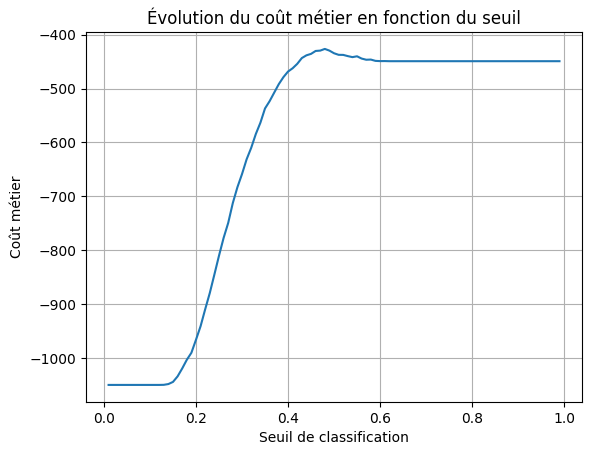

In [7]:
if 'n_estimators' in model_params:
    model_params['n_estimators'] = max(best_model_scores.items())[0]
elif 'C' in model_params:
    model_params['C'] = max(best_model_scores.items())[0]

best_model.set_params(**model_params)

best_pipeline = ImbPipeline(steps=[("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("model", best_model)])

# Entraîner le pipeline sur l'ensemble d'entraînement
best_pipeline.fit(X_train, y_train)

# Signature pour MLFlow
signature = infer_signature(X_train, best_pipeline.predict(X_train))

# Log le modèle avec la signature dans MLflow
with mlflow.start_run(run_name="Best Model"):
    # Log des hyperparamètres du meilleur modèle
    mlflow.log_params(best_params)
    
    # Log des métriques
    accuracy = accuracy_score(y_test, best_pipeline.predict(X_test))
    roc_auc = roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, best_pipeline.predict(X_test))
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("f1_score", f1)
    
    # Log du modèle dans MLflow
    mlflow.sklearn.log_model(best_pipeline, "model", signature=signature)

costs = []
thresholds = np.linspace(0.01, 0.99, 99)
best_threshold = 0
best_cost = -float('inf')

with mlflow.start_run(run_name="Best Threshold"):
    for threshold in thresholds:
        # Prédictions de probabilités
        y_pred_prob = best_pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_prob > threshold).astype(int)

        # Calculer le coût métier
        cost = custom_metric(y_test, y_pred, X_test)
        mlflow.log_metric(f"cost_threshold_{threshold:.2f}", cost)  # Log des coûts intermédiaires
        costs.append(cost)

        if cost > best_cost:
            best_cost = cost
            best_threshold = threshold

    # Loguer le meilleur seuil et le coût associé
    mlflow.log_param("best_threshold", best_threshold)
    mlflow.log_metric("best_cost", best_cost)

print(f"Meilleur seuil : {best_threshold} avec un coût de {best_cost}")
print()

# Visualisation
plt.plot(thresholds, costs)
plt.xlabel('Seuil de classification')
plt.ylabel('Coût métier')
plt.title('Évolution du coût métier en fonction du seuil')
plt.grid(True)
plt.show()

Le graphique ci-dessus permet d’identifier un seuil de probabilité optimal de 0.48, qui a minimisé les pertes avec une valeur de -426.53. Ces résultats indiquent les éléments suivants :
- Un seuil de 0.48 signifie que les transactions ou les observations ayant une probabilité supérieure à 48 % d’appartenir à la classe positive seront classées comme telles. Ce seuil est légèrement inférieur au seuil par défaut de 0.5, ce qui pourrait indiquer une préférence pour la détection des cas positifs au détriment d’une augmentation modérée des faux positifs.
- Le coût final obtenu est de -426.53, ce qui représente une amélioration par rapport aux valeurs précédentes observées durant l’entraînement. Cela montre que le modèle, avec ce seuil ajusté, est plus performant en termes d’impact métier que lorsqu’un seuil standard était utilisé.
L’optimisation de ce seuil est donc cruciale pour aligner les résultats du modèle avec les priorités spécifiques de l’entreprise ou du projet.

L’étape suivante consiste donc à approfondir l’interprétation du modèle sélectionné grâce à l’analyse des valeurs SHAP (SHapley Additive exPlanations). Cette méthode permet de comprendre les contributions individuelles de chaque variable dans les prédictions du modèle. En effet, après avoir optimisé les hyperparamètres et le seuil de probabilité, il est important de comprendre comment chaque caractéristique impacte les prédictions, en particulier dans des contextes sensibles comme la détection de fraude ou la prise de décision médicale.
L’analyse SHAP mettra ainsi en lumière les variables les plus influentes dans la prise de décision du modèle. Cela aide à valider que le modèle repose sur des facteurs pertinents et à éviter des biais éventuels. Dans cette démarche, les visualisations SHAP, comme les diagrammes "beeswarm", permettent de présenter les résultats à des parties prenantes non techniques, en rendant les modèles complexes plus compréhensibles.

Le prochain bloc de code utilisera donc SHAP pour analyser les contributions des variables au sein du modèle sélectionné. Il commencera d'abord par prétraiter les données à l’aide du pipeline de prétraitement. Ensuite, en fonction du type de modèle choisi (arbres de décision, boosting, ou régression logistique), il appliquera l’explainer SHAP le plus adapté :
- TreeExplainer pour les modèles basés sur des arbres (Random Forest, Gradient Boosting, LightGBM).
- Explainer générique pour les modèles non basés sur des arbres (comme la régression logistique).

Les valeurs SHAP calculées sont ensuite visualisées à l’aide d’un diagramme beeswarm pour illustrer l’impact de chaque variable sur les prédictions. En résumé, cette étape vise à compléter l’entraînement et l’optimisation du modèle par une analyse explicative, renforçant ainsi la confiance et la compréhension des résultats obtenus.

C:\Users\Alex-\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


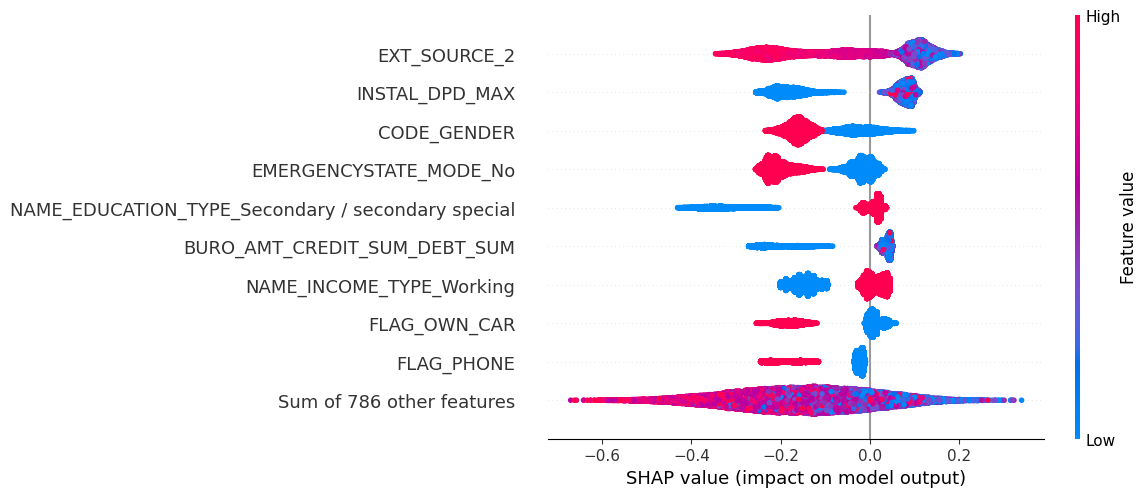

In [8]:
import shap

preprocess = ImbPipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=42))]).fit(X_train, y_train)

X_train_preprocessed = preprocess.named_steps["preprocessor"].transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)

if isinstance(best_pipeline.named_steps["model"], DummyClassifier):
    print("SHAP n'est pas pertinent pour DummyClassifier.")
else:
    if isinstance(best_pipeline.named_steps["model"], (RandomForestClassifier, GradientBoostingClassifier, LGBMClassifier)):
        explainer = shap.TreeExplainer(best_pipeline.named_steps["model"])
    else:
        explainer = shap.Explainer(best_pipeline.named_steps["model"], X_train_preprocessed)

    shap_values = explainer(X_train_preprocessed)

    # Gestion des valeurs SHAP multi-dimensionnelles
    if shap_values.values.ndim > 2:  # Multi-classe
        class_index = 0  # Sélectionnez une classe cible ou bouclez sur les classes
        shap_values_for_class = shap_values[..., class_index]
        shap.plots.beeswarm(shap_values_for_class)
    else:
        shap.plots.beeswarm(shap_values)

L'analyse des principales variables explicatives identifiées à partir des valeurs SHAP met en lumière les facteurs qui influencent le plus les prédictions du modèle. Voici une interprétation de ces variables :
- EXT_SOURCE_2 : Cette variable, représentant un score normalisé provenant d'une source externe, semble être l'un des indicateurs les plus significatifs. Sa corrélation probable avec la solvabilité ou la stabilité financière du client explique son importance dans les décisions du modèle.
- INSTAL_DPD_MAX : Le nombre maximal de jours de retard (DPD) pour un crédit précédent est un puissant indicateur de la capacité passée du client à respecter ses obligations financières. Un DPD élevé pourrait signaler des risques accrus.
- CODE_GENDER : Le genre du client joue également un rôle dans les prédictions, reflétant peut-être des tendances historiques ou des différences dans les comportements financiers selon le genre.
- EMERGENCYSTATE_MODE_No : L'absence d'informations sur l'état du bâtiment ou ses caractéristiques (par exemple, taille, âge, nombre d'étages ou d'ascenseurs) semble influencer le modèle. Cela pourrait indiquer que les données manquantes ou imprécises sont prises en compte comme un signal en soi.
- NAME_EDUCATION_TYPE_Secondary / secondary special : Le niveau d'éducation secondaire ou spécialisé est un marqueur important, souvent lié au potentiel de revenus ou à la stabilité de l'emploi.
- BURO_AMT_CREDIT_SUM_DEBT_SUM : Le montant total des dettes en cours, tel que rapporté par le Bureau de crédit, est un indicateur direct de la charge financière actuelle du client. Une dette élevée pourrait être un facteur de risque.
- NAME_INCOME_TYPE_Working : Le fait que le principal revenu provienne d'un emploi est un indicateur clé, reflétant une certaine stabilité économique pour les clients qui travaillent.
- FLAG_OWN_CAR : La possession d'une voiture peut être un signal de solvabilité, indiquant un certain niveau de revenu disponible ou de biens matériels.
- FLAG_PHONE : La présence ou l'absence d'un téléphone fixe peut refléter le niveau d'organisation ou d'accessibilité du client, bien que son poids explicatif soit probablement plus faible par rapport aux autres variables.

Ces variables montrent que le modèle s'appuie sur des facteurs financiers (dettes, antécédents de crédit), des indicateurs socio-économiques (éducation, type de revenu) et des informations générales (genre, propriété de biens) pour évaluer la probabilité d'un résultat donné. L'importance de variables comme EXT_SOURCE_2 et INSTAL_DPD_MAX illustre le poids des données externes et des antécédents financiers dans les décisions du modèle.

Le prochain code va plus loin dans l'interprétation des résultats SHAP, en générant des graphiques spécifiques, notamment des waterfall plots. Ces graphiques permettent de visualiser en détail les contributions de chaque variable pour une instance donnée, illustrant comment chaque facteur influence la prédiction finale.
Dans ce code, l'objectif est :
- De sélectionner une instance particulière (ici, la 200ᵉ) pour illustrer les contributions des variables explicatives.
- De différencier les modèles (par exemple, les modèles basés sur des arbres comme Random Forest ou Gradient Boosting utilisent un TreeExplainer, tandis que les modèles linéaires comme la régression logistique utilisent Explainer).
- De produire un waterfall plot pour l'instance sélectionnée, qui montrera l'effet cumulatif des variables, depuis la valeur de base (ou prédiction moyenne) jusqu'à la prédiction spécifique.

Cette étape permettra de mieux comprendre les décisions individuelles du modèle et d’évaluer sa transparence pour des cas spécifiques, renforçant ainsi la confiance dans son utilisation.

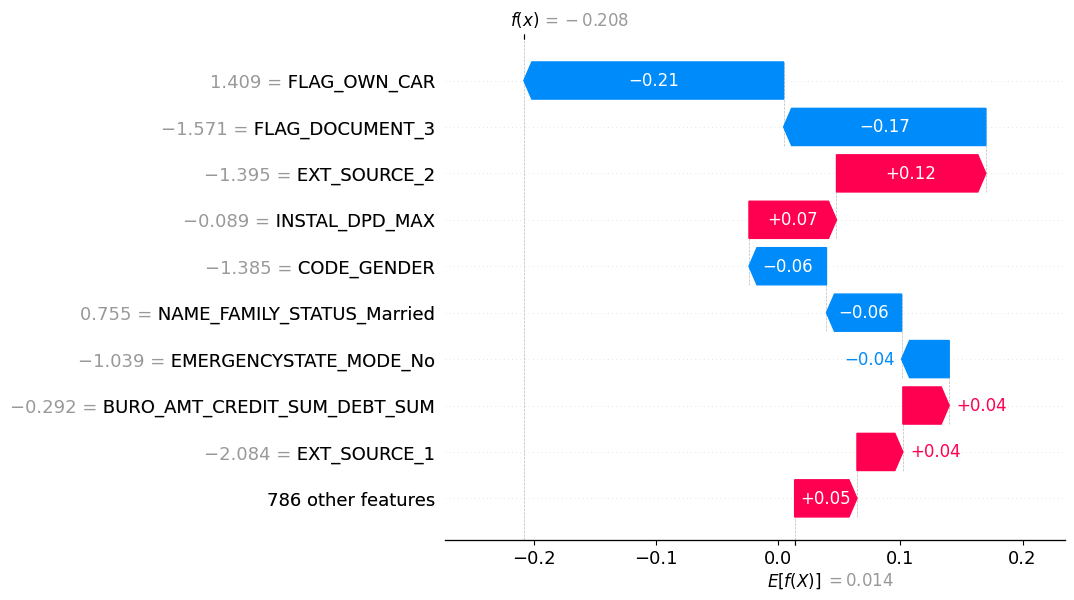

In [9]:
if isinstance(best_pipeline.named_steps["model"], DummyClassifier):
    print("SHAP n'est pas pertinent pour DummyClassifier.")
else:
    if isinstance(best_pipeline.named_steps["model"], (RandomForestClassifier, GradientBoostingClassifier, LGBMClassifier)):
        # Appliquer TreeExplainer après l'ajustement du modèle
        explainer = shap.TreeExplainer(best_pipeline.named_steps["model"])
    else:
        # Appliquer Explainer pour d'autres modèles (par exemple, LogisticRegression)
        explainer = shap.Explainer(best_pipeline.named_steps["model"], X_train_preprocessed)

    # Calculer les valeurs SHAP
    shap_values = explainer(X_train_preprocessed)

    # Gestion des valeurs SHAP multi-classe
    if shap_values.values.ndim > 2:  # Multi-classe
        class_index = 0  # Sélectionner une classe cible
        shap_values_for_class = shap_values[..., class_index]
        shap.plots.waterfall(shap_values_for_class[200], max_display=10)
    else:
        # Affichage du waterfall plot pour une instance spécifique
        shap.plots.waterfall(shap_values[200], max_display=10)

L’analyse réalisée tout au long de ce notebook a permis de construire, d’évaluer et d’interpréter un modèle de machine learning destiné à résoudre un problème métier précis. Voici les points clés de cette démarche et les enseignements principaux :
- Construction et optimisation du modèle : parmi les différentes architectures testées (DummyClassifier, Random Forest, Gradient Boosting, LightGBM, etc.), un modèle optimisé a été sélectionné sur la base de la meilleure performance au score personnalisé. Ensuite, des ajustements ont permis de déterminer des paramètres optimaux, notamment pour le nombre d'estimateurs (autour de 158 à 162) ou le paramètre de régularisation pour des modèles comme la régression logistique.
- Ajustement du seuil de probabilité : Le choix d’un seuil de 0,48 s’est avéré crucial pour optimiser la métrique métier, permettant d’atteindre un coût minimal de -426.53. Cela montre l'importance d'adapter le seuil de décision en fonction des priorités stratégiques.
- Interprétation et transparence du modèle : Les résultats ont mis en lumière les variables clés influençant les décisions du modèle. Ces analyses démontrent que le modèle se base sur des signaux pertinents, validant sa robustesse et sa cohérence métier. Enfin, à travers des waterfall plots, il a été possible de comprendre en profondeur les contributions spécifiques de chaque variable pour des cas individuels. Cette transparence est essentielle pour justifier les décisions du modèle auprès des parties prenantes.

Bien que les résultats obtenus soient prometteurs, plusieurs étapes complémentaires doivent être envisagées pour affiner et déployer le modèle :
- Validation sur des données externes : Tester le pipeline sur des jeux de données externes ou provenant de périodes différentes pour évaluer la robustesse et la généralisation du modèle.
- Déploiement opérationnel : utiliser des outils comme MLflow pour le suivi des performances du modèle en production et créer des API ou intégrer le modèle dans les processus métiers existants pour un usage pratique.
- Surveillance en production : Mettre en place un système de monitoring pour vérifier que les performances du modèle restent stables dans le temps. Cela inclut le suivi des métriques métier (ex. : coût), la détection de dérive des données (data drift) et l'enrichissement des données.

Ce notebook illustre un processus rigoureux de développement et d’analyse d’un modèle prédictif, depuis la construction du pipeline jusqu’à l’interprétation détaillée des résultats. En combinant performance, optimisation et transparence, ce travail pose des bases solides pour un déploiement opérationnel réussi. Les étapes suivantes permettront d’élargir l’impact de ce modèle en renforçant sa robustesse, son accessibilité et sa fiabilité dans des contextes réels.